# **Sentiment Analysis on Film Reviews with Transformers**
### In this sentiment analysis project, I'm using Python and Transformers , a state-of-the-art deep learning algorithm for natural language processing. The goal of this project is to classify the sentiment of text data, film reviews here, into positive, negative, or neutral categories. By using Transformers, I can leverage pre-trained language models to improve the accuracy of the sentiment classification.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
dataset_dir = "/content/gdrive/MyDrive/NLP/Sentiment Analysis/ichi_the_killer_imdb_reviews.csv"

In [ ]:
!pip install transformers

In [5]:
# Load Dependancies
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))
from transformers import pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Data Preprocessing**

In [6]:
# Load Data
df = pd.read_csv(dataset_dir)
df.head()

,Rating,Review_Title,Review
0,7.0,A mixed bag for me\n,Ichi the Killer is the story of a Yakuza gang ...
1,9.0,Excellent mix of sadistic violence and humour.\n,"Takashi Miike's ""Ichi the Killer"" is a masterp..."
2,8.0,Genuinely disturbing and intensely shocking b...,Ichi the Killer is definitely not a film for p...
3,7.0,Love Hurts\n,"Ichi the Killer, is hands down the number one ..."
4,9.0,Absolutely amazing!\n,You know those revenge stories that are so oft...


In [7]:
# Basic Info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rating        276 non-null    float64
 1   Review_Title  324 non-null    object 
 2   Review        324 non-null    object 
dtypes: float64(1), object(2)
memory usage: 7.7+ KB


In [8]:
# Analyze missing data
print(f"Missing Values per Column:\n{df.isnull().sum()}")

Missing Values per Column:
Rating          48
Review_Title     0
Review           0
dtype: int64


In [9]:
# Split Dataset into Clean, Raw and Test
df_raw = df.copy()
df_train = df.dropna().copy()
df_test = df[df['Rating'].isna()].copy()
print(f'df_raw shape: {df_raw.shape} | df_train shape: {df_train.shape} | df_test shape: {df_test.shape}')

df_raw shape: (324, 3) | df_train shape: (276, 3) | df_test shape: (48, 3)


### **Text Processing**

In [10]:
# Text Cleaning / Remove Punctutation 
clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"
punct = r'[!"\#\$%\&\'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~]'

df_raw['Review_Title'] = df_raw['Review_Title'].str.replace(clean_pattern, ' ', regex=True)
df_raw['Review'] = df_raw['Review'].str.replace(clean_pattern, ' ', regex=True)

df_train['Review_Title'] = df_train['Review_Title'].str.replace(clean_pattern, ' ', regex=True)
df_train['Review'] = df_train['Review'].str.replace(clean_pattern, ' ', regex=True)

df_test['Review_Title'] = df_test['Review_Title'].str.replace(clean_pattern, ' ', regex=True)
df_test['Review'] = df_test['Review'].str.replace(clean_pattern, ' ', regex=True)

In [11]:
# Most Frequent Words
def get_top_words(column, n=20):
    """
    Given a column of a dataframe, returns the top n most frequent words in that column
    """
    # Convert all text to lowercase
    column = column.str.lower()    
    # Concatenate all the strings in the column
    text = ' '.join(column.values)
    # Split the text into words
    words = text.split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Return the top n most frequent words
    return pd.DataFrame(word_counts.most_common(n),columns=['Word','Count'])

In [12]:
# Generate Stop Words
top_words = get_top_words(df_train['Review'], n=150) # Fetch top 150 most frequent workds
nltk_stopwords = stopwords.words('english')
stop_words = [word for word in top_words.iloc[:,0]]
additional_stopwords = ['guy','end','look','kind','take','yet','come','makes','though','want'] # Generated by examining word cloud plots
merged_stopwords = nltk_stopwords+stop_words+additional_stopwords

In [13]:
# Cleaning all 324 Reviews
text_body1 = ' '.join(df['Review'].tolist())
text_body2 = ' '.join(df['Review_Title'].tolist())

text_body1 = re.sub(clean_pattern,  ' ', text_body1)
text_body1 = re.sub('\n',  '', text_body1)
text_body1 = re.sub(punct,  ' ', text_body1)

text_body2 = re.sub(clean_pattern,  ' ', text_body2)
text_body2 = re.sub('\n',  '', text_body2)
text_body2 = re.sub(punct,  ' ', text_body2)

text_body1 = text_body1.lower()
text_body2 = text_body2.lower()

text_combined = text_body1 + text_body2

## **Data Vizualization**

In [14]:
# Rating Distribution
df_train = df_train.astype({'Rating':'float'})
df_train = df_train.sort_values('Rating')
color_seq = ['rgb(255,247,236)', 'rgb(254,232,200)', 'rgb(253,212,158)', 'rgb(253,187,132)', 'rgb(252,141,89)', 'rgb(239,101,72)', 'rgb(215,48,31)', 'rgb(195,0,0)', 'rgb(155,0,0)', 'rgb(125,0,0)']
rating_dist = px.histogram(df_train,
             x = 'Rating',
             title = 'Ichi The Killer (2001) by Takashi Miike',
             template = 'plotly_white',
             color = 'Rating',
             color_discrete_sequence = color_seq,
             #opacity = 0.8,
             height = 512,
             width = 512,
            )

rating_dist.update_layout(
    title = {'text': 'Ichi The Killer (2001) by Takashi Miike', 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=20, color='black', family='trebuchet ms, sans-serif')},
    yaxis_title='Count', yaxis_title_font=dict(size=16, color='black', family='trebuchet ms, sans-serif'),
    annotations=[dict(text=f'Rating distribution based on {df_train.shape[0]} written reviews on IMdB', x=0.5, y=1.1, showarrow=False, xref='paper', yref='paper', font=dict(size=14, family='trebuchet ms, sans-serif'))],
    showlegend=False
)

rating_dist.show()

In [15]:
# Masking Image for Word Cloud
import numpy as np
from PIL import Image
mask_image = Image.open("/content/gdrive/MyDrive/NLP/Sentiment Analysis/filmcamera.png").convert('L')
mask_array = np.array(mask_image)

In [16]:
# Color Theme for Word Cloud
color = np.array(Image.open("/content/gdrive/MyDrive/NLP/Sentiment Analysis/color.jpg"))
image_colors = ImageColorGenerator(color)

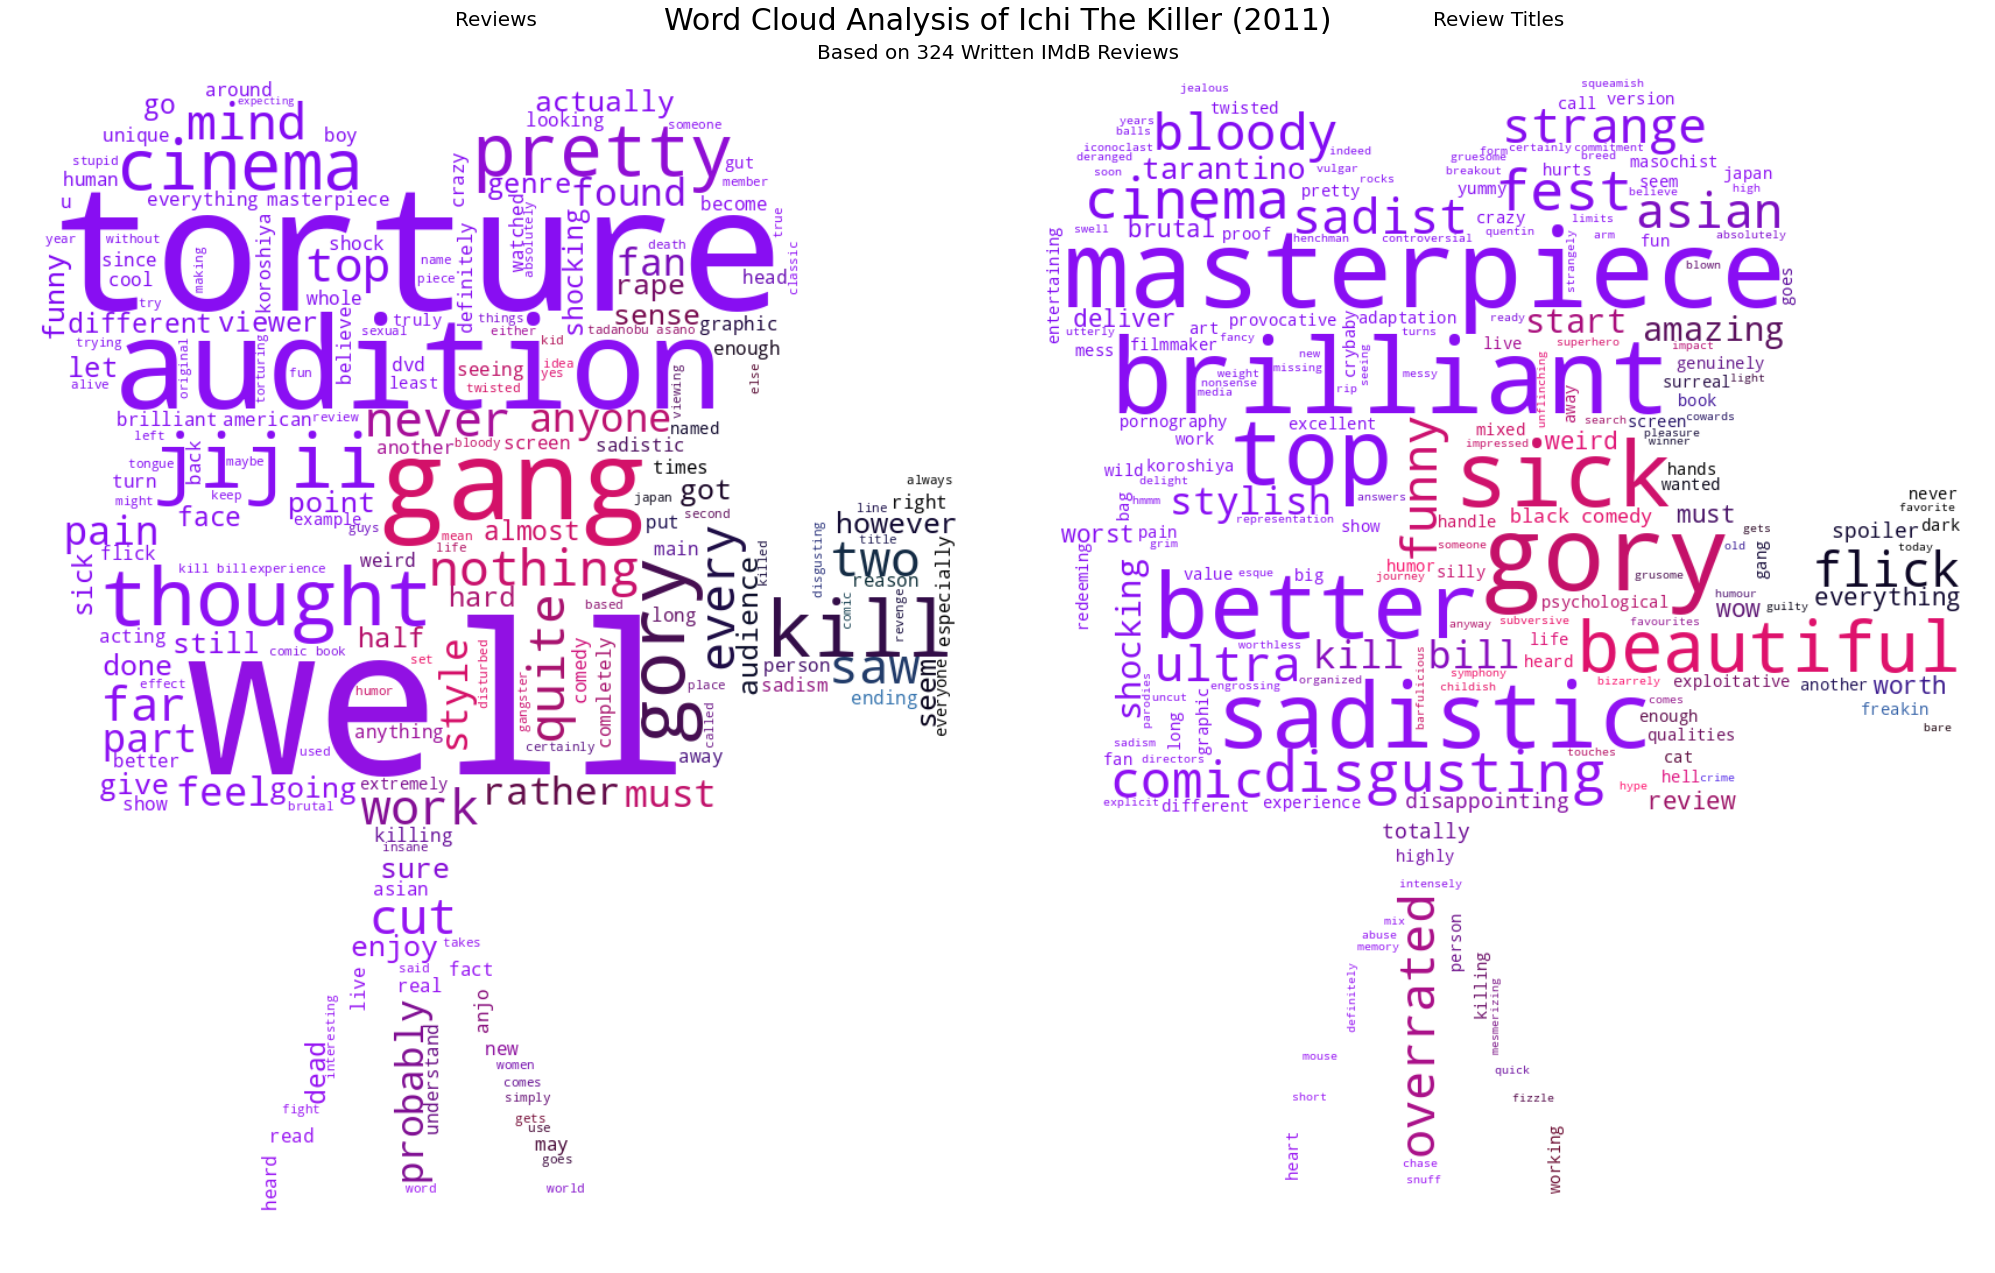

In [17]:
# Generate Word Clouds for Review and Review Titles Seperately
reviews_text = text_body1
reviews_wc = WordCloud(width=800, height=400, background_color='white', mask=mask_array, stopwords=merged_stopwords).generate(reviews_text)
reviews_wc.recolor(color_func=image_colors)

titles_text = text_body2
titles_wc = WordCloud(width=800, height=400, background_color='white', mask=mask_array, stopwords=merged_stopwords).generate(titles_text)
titles_wc.recolor(color_func=image_colors)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(28,18))
fig.set_facecolor('white')
fig.suptitle('Word Cloud Analysis of Ichi The Killer (2011)', fontsize=30)
fig.text(0.5, 0.94, 'Based on 324 Written IMdB Reviews', ha='center', fontsize=20)
axs[0].imshow(reviews_wc, interpolation='bilinear')
axs[0].set_title('Reviews', fontsize=20)
axs[0].axis('off')
axs[1].imshow(titles_wc, interpolation='bilinear')
axs[1].set_title('Review Titles', fontsize=20)
axs[1].axis('off')
plt.tight_layout()
#plt.savefig('wordclouds.jpg',dpi=1000)
plt.show()

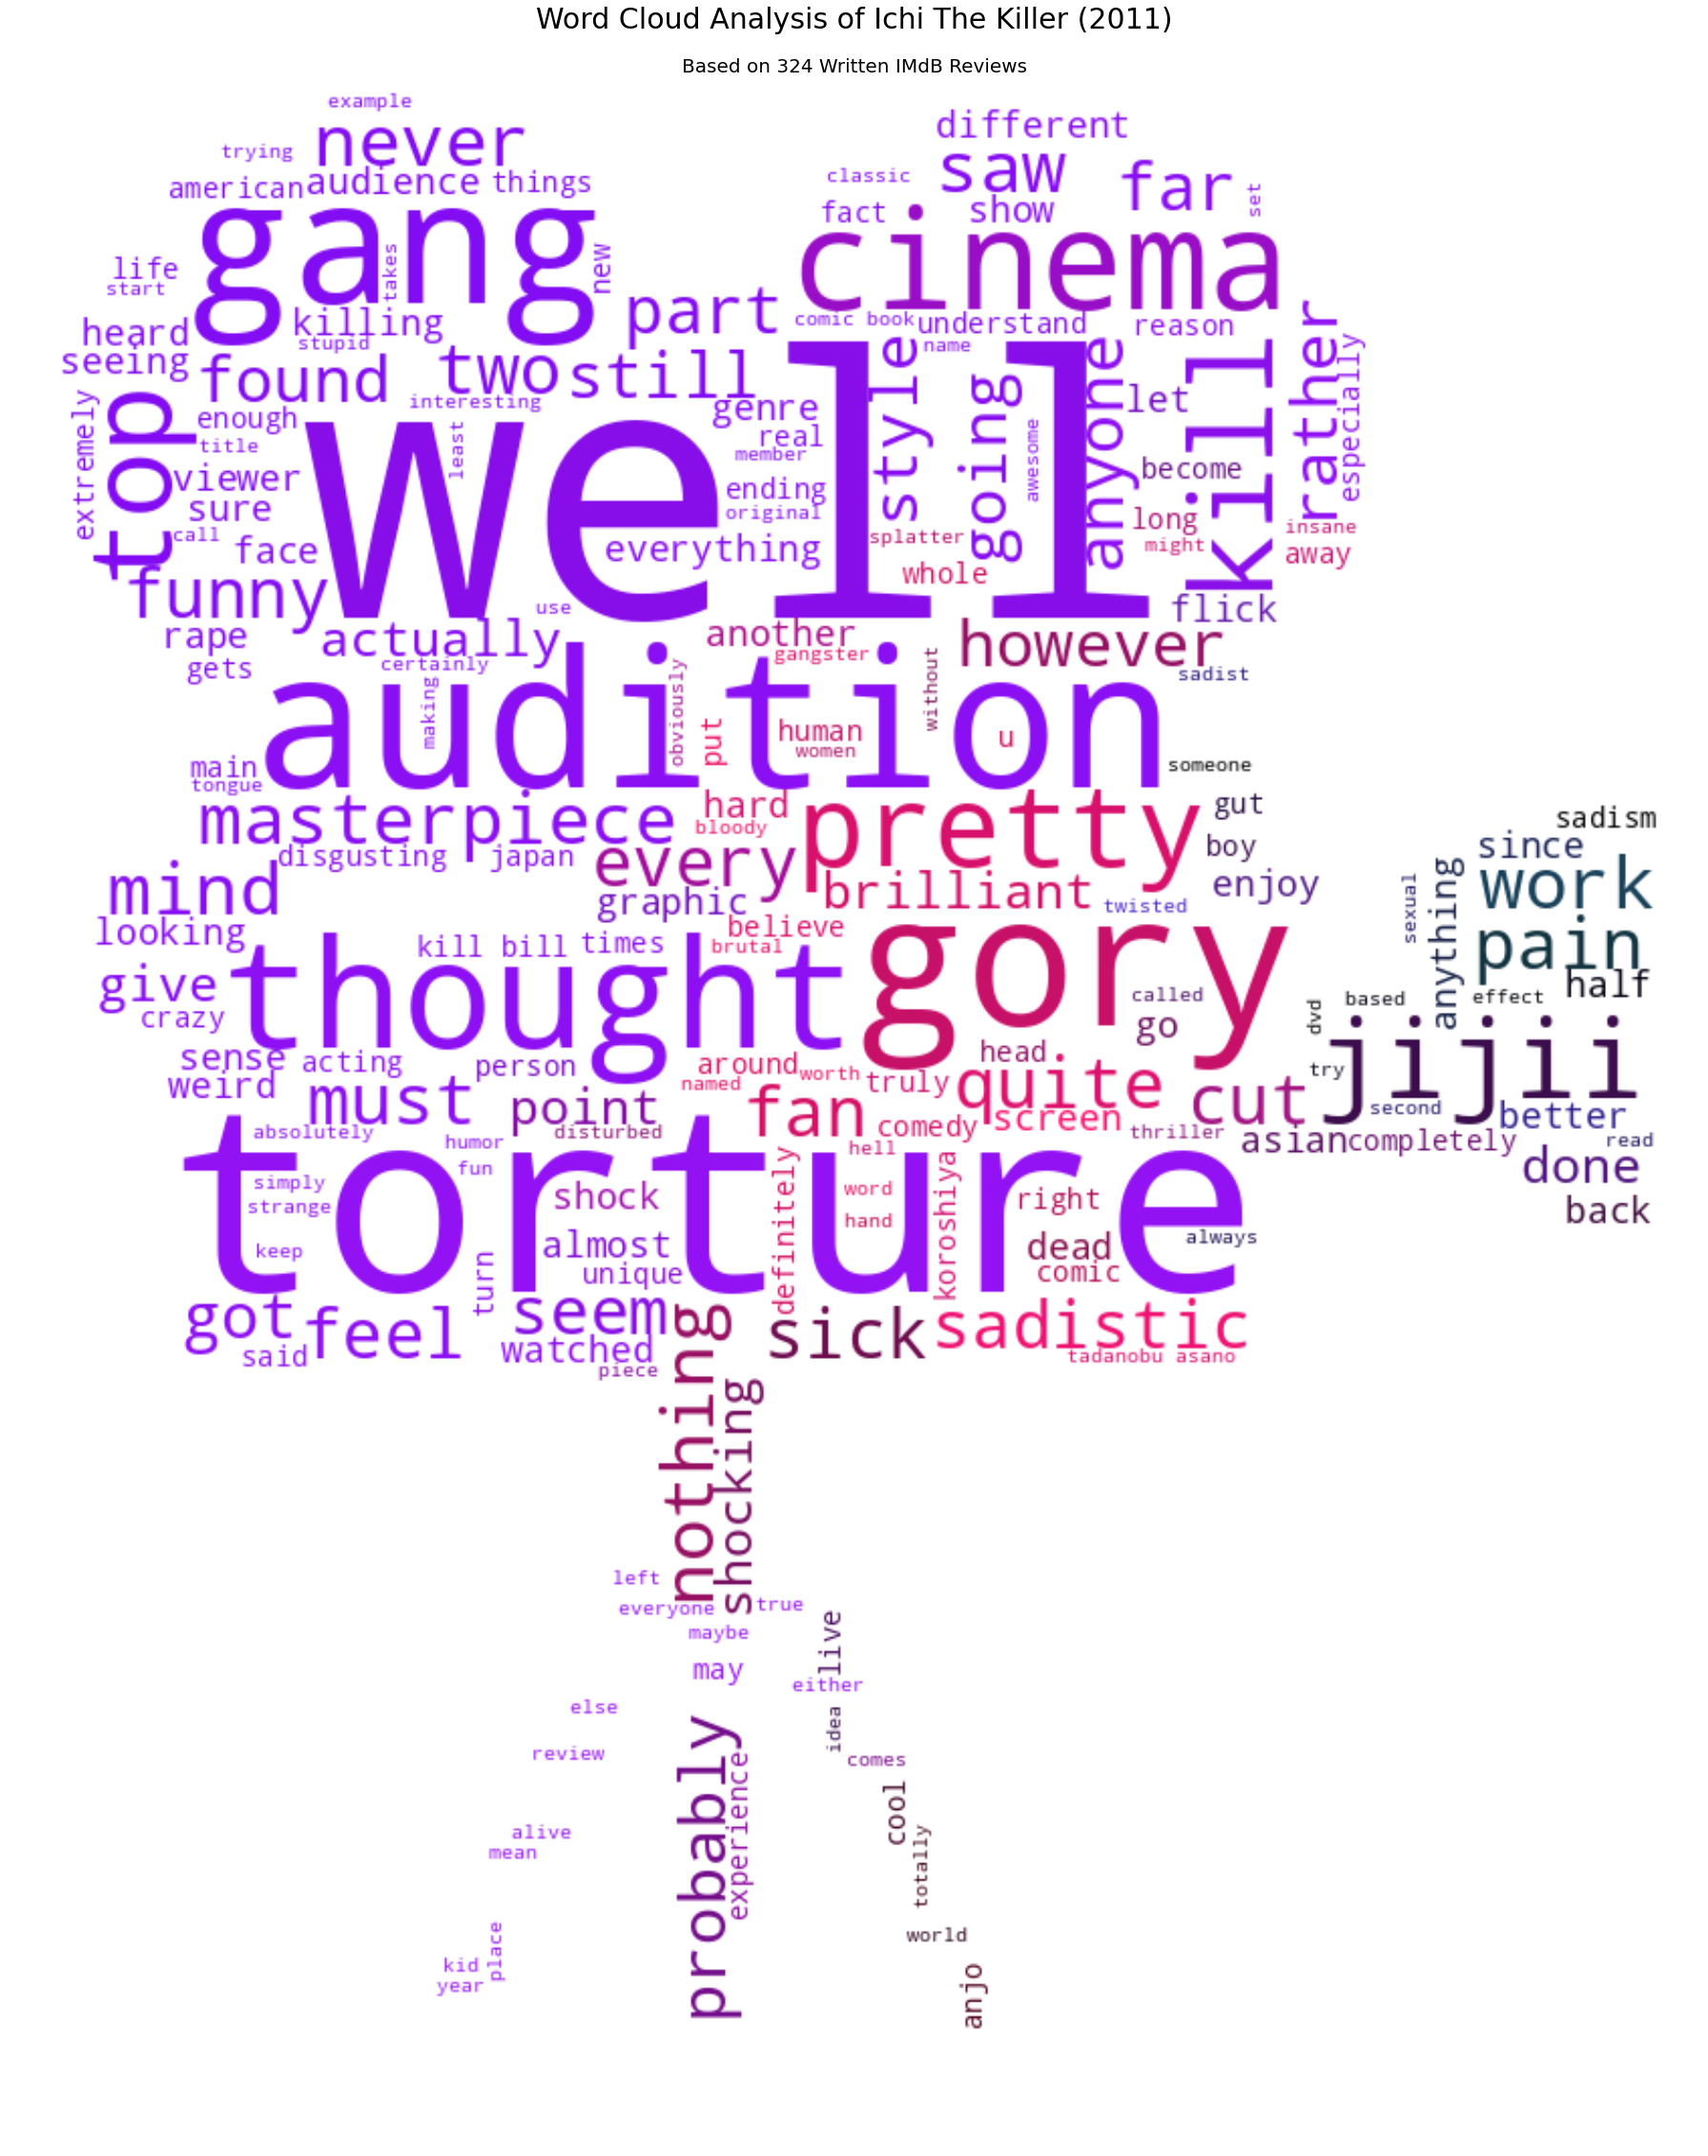

In [18]:
# Generate Word Clouds for The Entire Text Combined
combined_text = text_combined
combined_wc = WordCloud(width=800, height=400, background_color='white', mask=mask_array, stopwords=merged_stopwords).generate(combined_text)
combined_wc.recolor(color_func=image_colors)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(32,32))
fig.set_facecolor('white')
fig.suptitle('Word Cloud Analysis of Ichi The Killer (2011)', fontsize=30)
fig.text(0.5, 0.95, 'Based on 324 Written IMdB Reviews', ha='center', fontsize=20)
axs.imshow(combined_wc, interpolation='bilinear')
axs.axis('off')
plt.tight_layout()
#plt.savefig('wordcloud_combined.jpg', dpi=1000)
plt.show()

## **Sentiment Analysis**

In [ ]:
# Uses the default model: distilbert-base-uncased-finetuned-sst-2-english
sentiment_pipeline = pipeline("sentiment-analysis")
# Wrapper function to get sentiment label and score:
def get_sentiment(text):
  label = sentiment_pipeline(text)[0]['label']
  return label
def get_score(text):
  score = sentiment_pipeline(text)[0]['score']
  return score

In [54]:
# Drop reviews longer than 512 tokens (max token length of DistilBERT)
df_raw['Review_Length'] = df_raw['Review'].apply(len)
df_short = df_raw[df_raw['Review_Length']<=512]
print(f'Reviews Longer than 512 Tokens: {df_raw.shape[0]}, Shorter: {df_short.shape[0]}')

Reviews Longer than 512 Tokens: 324, Shorter: 164


In [55]:
# create new columns with sentiment features
df_short['Title_Sentiment'] = df_short['Review_Title'].apply(get_sentiment)
df_short['Title_Score'] = df_short['Review_Title'].apply(get_score)
df_short['Review_Sentiment'] = df_short['Review'].apply(get_sentiment)
df_short['Review_Score'] = df_short['Review'].apply(get_score)

In [59]:
# Sentiment Distribution of Reviews
rating_dist = px.histogram(df_short,
             x = 'Review_Sentiment',
             title = 'Ichi The Killer (2001) by Takashi Miike',
             template = 'plotly_white',
             color = 'Review_Sentiment',
             height = 512,
             width = 512,
            )

rating_dist.update_layout(
    title = {'text': 'Ichi The Killer (2001) by Takashi Miike', 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=20, color='black', family='trebuchet ms, sans-serif')},
    yaxis_title='Count', yaxis_title_font=dict(size=16, color='black', family='trebuchet ms, sans-serif'),
    annotations=[dict(text=f'Sentiment (Review) distribution based on {df_short.shape[0]} written reviews on IMdB', x=0.5, y=1.1, showarrow=False, xref='paper', yref='paper', font=dict(size=14, family='trebuchet ms, sans-serif'))],
    showlegend=False
)

rating_dist.show()

In [60]:
# Sentiment Distribution of Review Title
rating_dist = px.histogram(df_short,
             x = 'Title_Sentiment',
             title = 'Ichi The Killer (2001) by Takashi Miike',
             template = 'plotly_white',
             color = 'Title_Sentiment',
             height = 512,
             width = 512,
            )

rating_dist.update_layout(
    title = {'text': 'Ichi The Killer (2001) by Takashi Miike', 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=20, color='black', family='trebuchet ms, sans-serif')},
    yaxis_title='Count', yaxis_title_font=dict(size=16, color='black', family='trebuchet ms, sans-serif'),
    annotations=[dict(text=f'Sentiment (Review Title) distribution based on {df_short.shape[0]} written reviews on IMdB', x=0.5, y=1.1, showarrow=False, xref='paper', yref='paper', font=dict(size=14, family='trebuchet ms, sans-serif'))],
    showlegend=False
)

rating_dist.show()

## **Review Summerizer**

In [67]:
# Initialize summerizer model: bart-large-cnn-samsum
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
# Wrapper function to summarize reviewes
def summarize(text):
  summary = summarizer(text,max_length=52)[0]['summary_text']
  return summary

In [ ]:
# Create summary column
df_short['Review_Summary'] = df_short['Review'].apply(summarize)
df_short.head(5)

In [71]:
# Save dataframe
df_short.to_csv('sentiments_summaries.csv')

In [91]:
# Sampling Summaries
#df_short = df_short.reset_index()
print(f"Review: {df_short['Review'][1]} \nReview Summary: {df_short['Review_Summary'][1]}")

Review: You know those revenge stories that are so often used in various Asian cinema, the ones that involve, like, Jackie Chan killing the killers of his brother or whatever  This film is NOTHING like that. However, that's as close of a basic foundational structure I can give you to help explain this amazing psychological look into a world defined by violence and masochism. 
Review Summary: This film is nothing like the usual revenge stories used in Asian cinema. It's an amazing psychological look into a world defined by violence and masochism. It is not about killing the killers of Jackie Chan's brother, but it's about revenge.  
